# **ResNet CIFAR-10**

### 각 코드 블럭을 실행하여 학습과 검증을 완료하고 코드 블럭 아래에 있는 서술형 문제(Q)에 답하시오.

**[Overview]**
1. 라이브러리 설정
2. GPU 설정
3. Data 준비
4. 모델 설계
5. 모델 훈련 (Training)
6. 모델 검증 (Testing)

**라이브러리**

In [1]:
import torch #pytorch 사용
import torch.nn as nn # neural network library from pytorch 사용
import torch.nn.functional as F # pytorch 내부의 F 함수 사용
import torch.optim as optim # optimizer 사용
import torchvision
from torchvision import datasets, transforms  #dataset 불러오기 위해 사용
import matplotlib.pyplot as plt # 시각화를 위한 matplotlib 사용
from torch.utils.data import DataLoader #Data를 batch_size로 나누기 위해 사용
from tqdm.notebook import tqdm

**GPU 설정**
 - cpu: 최대 24코어
 - gpu: 단순한 연산(floating point) 덧셈 뺄셈 곱셈 나눗셈만 이것만 전문으로 하는 코어들을 수천개씩 가지고 있다
 - 딥러닝은 기본적으로 행렬 곱하기 연산이기 때문에 딥러닝에는 gpu가 적합하다

In [2]:
! nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Wed Aug 13 13:52:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Data 준비**

In [3]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=128)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


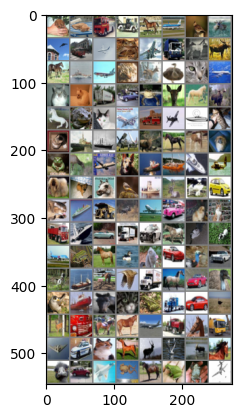

dog   cat   truck truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


**VGG 모델 설계**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block 구조 정의
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()

        # stride를 통해 너비와 높이 조정
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)

        # stride = 1, padding = 1이므로, 너비와 높이는 항시 유지됨
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        # x를 그대로 더해주기 위함
        self.shortcut = nn.Sequential()

        # 만약 size가 안맞아 합연산이 불가하다면, 연산 가능하도록 모양을 맞춰줌
        if stride != 1: # x와
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # 필요에 따라 layer를 Skip
        out = F.relu(out)
        return out

class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()

        #첫 Convolution은 너비와 높이 downsampling
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)

        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.conv3 = nn.Conv2d(out_planes, out_planes*self.mul, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes*self.mul)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != out_planes*self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes*self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes*self.mul)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out





class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        #RGB 3개채널에서 64개의 Kernel 사용
        self.in_planes = 64

        # Resnet 논문 구조 그대로 구현
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512 * block.mul, num_classes)

    def make_layer(self, block, out_planes, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [6]:
device = 'cuda'
model = ResNet50()
model = model.to(device)
# ResNet18, ResNet34, ResNet50, ResNet101, ResNet152 중에 택일하여 사용
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

### Q. 위 ResNet 구현에서 projection shortcut이 적용되는 지점을 "코드 위치"와 “모델 스테이지별 발생 구간”의 두 관점으로 설명하시오.

단서는 다음과 같다.

	•	Identity shortcut 충분: H X W, 채널, stride가 모두 동일한 블록.
	•	Projection 필요: (1) stride 변경으로 공간 크기 달라짐, (2) 채널 수가 변함, (3) 정렬·scale 차이를 보정해야 함.


요구사항:

  1.	projection을 생성하는 조건을 만족하는 코드를 정확히 인용(또는 요약)하라.

  2.	ResNet-18/34와 ResNet-50/101/152에서 어느 스테이지의 어느 블록에서 projection이 쓰이는지, 이 코드의 make_layer 로직(첫 블록 stride 설정)과 함께 설명하라.

**YOUR ANSWER**: <br>
(a) BasicBLock <br>
self.shortcut = nn.Sequential()  <br>
if stride != 1:  <br>
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_planes)
    )
<br>

(b) BottleNeck <br>
self.shortcut = nn.Sequential()  <br>
if stride != 1 or in_planes != out_planes*self.mul:  <br>
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_planes, out_planes*self.mul, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_planes*self.mul)
    )

**YOUR ANSWER**: <br>
(1) ResNet-18/34 (BasicBlock) <br>
- BasicBlock에서는 stride가 1보다 큰 경우(다운샘플링)에 사용
- make_layer 구조상 layer2, layer3, layer4의 첫 번째 블록은 stride=2로 시작하므로 projection이 적용되고, layer1의 첫 번째 블록은 stride=1이라 projection이 없다
- 각 스테이지의 첫 블록 이후는 stride=1이므로 전부 identity shortcut 사용

(2) ResNet-50/101/152 (BottleNeck) <br>
- BottleNeck에서는 stride가 1이더라도 입력 채널 수와 출력 채널 수×4가 다르면 projection을 적용 => layer1의 첫 블록도 stride=1이지만 채널 수가 64→256으로 확장되므로 projection이 필요
- layer2~4의 첫 블록은 stride=2로 다운샘플링되면서 채널 수 확장도 함께 일어나 projection 적용
- 각 스테이지의 나머지 블록은 stride=1이고 채널 수가 이미 맞춰져 있으므로 identity shortcut 사용

**Hyperparameter 설정**

In [7]:
epochs = 10
lr = 2e-4

# seed
seed = 2891
torch.manual_seed = seed  #매번 같은 결과 값이 나오게 함

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [8]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]           4,096
       BatchNorm2d-5             [-1, 64, 8, 8]             128
            Conv2d-6             [-1, 64, 8, 8]          36,864
       BatchNorm2d-7             [-1, 64, 8, 8]             128
            Conv2d-8            [-1, 256, 8, 8]          16,384
       BatchNorm2d-9            [-1, 256, 8, 8]             512
           Conv2d-10            [-1, 256, 8, 8]          16,384
      BatchNorm2d-11            [-1, 256, 8, 8]             512
       BottleNeck-12            [-1, 256, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          16,384
      BatchNorm2d-14             [-1, 6

### Q. 위 summary를 보고 문제에 답하시오.

(a) 테이블에서 임의의 Bottleneck(예: 첫 스테이지의 첫 블록)을 하나 고르고, 그 안의 세 개 conv(1×1, 3×3, 1×1) 가중치 수를 직접 계산하라. (bias=False, BN 파라미터는 별도 집계)

(b) 같은 블록의 shortcut 분기가 projection인지 identity인지 판별하고, projection인 경우 1×1 conv의 파라미터 수도 계산하라.

(c) 같은 스테이지 내 identity shortcut만 쓰는 블록도 예시로 2개 골라, 해당 블록에서 identity가 충분한 이유를 코드/형상 관점에서 서술하라.


**YOUR ANSWER**: <br>
[첫 스테이지의 첫 블록의 세 개 conv(1×1, 3×3, 1×1) 가중치 수] <br>
- 1×1 conv (64 → 64, stride=1) : 출력 * 입력 * 1 * 1 = 64 * 64 = 4096
- 3×3 conv (64 → 64, stride=1, padding=1) : 64 * 64 * 3 * 3 = 36864
- 1×1 conv (64 → 256, stride=1) : 256 * 64 * 1 * 1 = 16384

**YOUR ANSWER**: <br>
입력 채널은 64, 출력채널은 256 이므로 in_planes(64) != out_planes*mul(256) <br>
=> projection shortcut 필요 <br>
- projection 1×1 conv 파라미터 수: 256 × 64 × 1 × 1 = 16384

**YOUR ANSWER**: <br>
layer1의 두 번째·세 번째 Bottleneck 블록은 stride=1 + in_planes=out_planes*mul=256 + 해상도 유지(8×8)로, identity shortcut만 사용

**Model 훈련(Training)**

In [9]:

tot_train_loss= []

for e in range(1, epochs+1):
    model.train()
    print(f"============= [Epochs] {e}/{epochs} =============")
    train_loss = 0.0
    for datas, labels in tqdm(train_loader):
        datas = datas.to(device)
        labels = labels.to(device)

        output = model(datas)
        loss = loss_fn(output, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    tot_train_loss.append(train_loss/len(train_loader))
    print(f"Loss: {train_loss/len(train_loader):.6f}")

    # 매 에폭마다 성능 차이를 보기 위해 실행
    with torch.no_grad(): # autograd 엔진을 비활성화
        model.eval() # dropout을 비활성화 시켜줌
        test_acc = 0.0
        for datas, labels in tqdm(test_loader):

            datas = datas.to(device)
            labels = labels.to(device)

            output = model(datas)

            preds = torch.argmax(output, dim=1)
            test_acc += preds.eq(labels).sum()

    print(f"[Epoch] {e}, [Test Result] {(test_acc/len(test_loader.dataset))*100:.3f}%")


============= [Epochs] 1/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 1.806989


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 1, [Test Result] 44.760%
============= [Epochs] 2/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 1.389657


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 2, [Test Result] 51.320%
============= [Epochs] 3/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 1.180758


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 3, [Test Result] 55.460%
============= [Epochs] 4/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 1.018100


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 4, [Test Result] 58.040%
============= [Epochs] 5/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.878131


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 5, [Test Result] 57.170%
============= [Epochs] 6/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.761545


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 6, [Test Result] 60.010%
============= [Epochs] 7/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.657972


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 7, [Test Result] 61.270%
============= [Epochs] 8/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.567677


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 8, [Test Result] 61.140%
============= [Epochs] 9/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.494834


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 9, [Test Result] 63.150%
============= [Epochs] 10/10 =============


  0%|          | 0/391 [00:00<?, ?it/s]

Loss: 0.419233


  0%|          | 0/79 [00:00<?, ?it/s]

[Epoch] 10, [Test Result] 62.340%


**7. Model 검증(Testing)**
* 모델이 잘 학습되었는지 검증

In [10]:
with torch.no_grad(): # autograd 엔진을 비활성화
    model.eval() # dropout을 비활성화 시켜줌
    test_acc = 0.0
    for datas, labels in tqdm(test_loader):

        datas= datas.to(device)
        labels= labels.to(device)

        output= model(datas)

        preds= torch.argmax(output, dim=1)
        test_acc+= preds.eq(labels).sum()

print(f"[Test Result] {(test_acc/len(test_loader.dataset))*100:.3f}%")

  0%|          | 0/79 [00:00<?, ?it/s]

[Test Result] 62.340%


## 추가 문제 (PPT 관련)

### Q. 다음 중 Shortcut Connection이 필요한 이유로 가장 적절하지 않은 것은 무엇인가요?

A. 입력 정보를 그대로 다음 레이어에 전달하기 위해

B. 깊은 네트워크에서도 gradient가 잘 흐르도록 하기 위해

C. 연산량을 줄이기 위해

D. 입력과 출력의 차원이 다를 때 덧셈을 가능하게 하기 위해


**YOUR ANSWER**: C

### Q. ResNet-18, ResNet-34, ResNet-50과 같은 다양한 ResNet 버전들이 존재한다.

이러한 버전들이 무엇을 의미하며, 왜 다양한 버전이 사용되는지 서술하라.

**YOUR ANSWER**:버전 뒤의 숫자는 네트워크의 깊이, 즉 모델의 전체 레이어 수를 의미한다. (ex. ResNet-50 → 50개의 학습 가능한 레이어 (BottleNeck 사용, channel 확장 구조) <br>
이는 연산량과 성능 간의 트레이드오프를 맞추기 위해 다양한 버전이 사용된다고 한다. <br>
(ex. 작은 모델(ResNet-18)은 파라미터 수와 연산량이 적어 실시간 처리나 임베디드 환경에 적합, 큰 모델(ResNet-50)은 더 깊고 복잡해 정확도 향상에 유리하지만, 학습 및 추론 속도가 느림)